<a href="https://colab.research.google.com/github/r-dube/fakejobs/blob/main/fj_ngram_tfidf_logistic.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Load the modules used
import numpy as np
import scipy as sci
import pandas as pd
import string
import re
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, roc_curve, roc_auc_score
from sklearn.linear_model import LogisticRegression
import matplotlib.pyplot as plt

In [2]:
# For reproducible results
# except for variability introduced by GPU
import random as rn
import os
os.environ['PYTHONHASHSEED'] = '42'
# os.environ['CUDA_VISIBLE_DEVICES'] = '-1' # avoid using GPU for reproducible results
np.random.seed(42)
rn.seed(42)
# tf.random.set_seed(42)

In [3]:
# Set data_url, the location of the data
# Data is not loaded from a local file
# data_url="https://raw.githubusercontent.com/r-dube/fakejobs/main/data/fj_small.csv"
# data_url="https://raw.githubusercontent.com/r-dube/fakejobs/main/data/fj_medium.csv"
data_url="https://raw.githubusercontent.com/r-dube/fakejobs/main/data/fake_job_postings.csv"

In [4]:
def fj_load_df_from_url():
    """
    Load dataframe from csv file
    Input:
        None
    Returns:
        dataframe
    """

    df = pd.read_csv(data_url)

    print ('Loaded dataframe shape', df.shape)

    counts = fj_label_stats(df)
    print ('Not fraudulent', counts[0], 'Fraudulent', counts[1])

    print(df.describe())

    print ('NAs/NANs in data =>')
    print(df.isna().sum())

    return df

def fj_label_stats(df):
    """
    Very basic label statistics
    Input: 
        Dataframe
    Returns:
        Number of samples with 0, 1 as the label
    """
    counts = np.bincount(df['fraudulent'])
    return counts

def fj_txt_only(df):
    """
    Combine all the text fields, discard everything else except for the label
    Input: 
        Dataframe
    Returns:
        Processed dataframe
    """
    
    df.fillna(" ", inplace = True)

    df['text'] = df['title'] + ' ' + df['location'] + ' ' + df['department'] + \
    ' ' + df['company_profile'] + ' ' + df['description'] + ' ' + \
    df['requirements'] + ' ' + df['benefits'] + ' ' + df['employment_type'] + \
    ' ' + df['required_education'] + ' ' + df['industry'] + ' ' + df['function'] 

    del df['title']
    del df['location']
    del df['department']
    del df['company_profile']
    del df['description']
    del df['requirements']
    del df['benefits']
    del df['employment_type']
    del df['required_experience']
    del df['required_education']
    del df['industry']
    del df['function']  
    
    del df['salary_range']
    del df['job_id']
    del df['telecommuting']
    del df['has_company_logo']
    del df['has_questions']

    return df

In [5]:
df = fj_load_df_from_url()
df = fj_txt_only(df)
print('Maximum text length', df['text'].str.len().max())

Loaded dataframe shape (17880, 18)
Not fraudulent 17014 Fraudulent 866
             job_id  telecommuting  ...  has_questions    fraudulent
count  17880.000000   17880.000000  ...   17880.000000  17880.000000
mean    8940.500000       0.042897  ...       0.491723      0.048434
std     5161.655742       0.202631  ...       0.499945      0.214688
min        1.000000       0.000000  ...       0.000000      0.000000
25%     4470.750000       0.000000  ...       0.000000      0.000000
50%     8940.500000       0.000000  ...       0.000000      0.000000
75%    13410.250000       0.000000  ...       1.000000      0.000000
max    17880.000000       1.000000  ...       1.000000      1.000000

[8 rows x 5 columns]
NAs/NANs in data =>
job_id                     0
title                      0
location                 346
department             11547
salary_range           15012
company_profile         3308
description                1
requirements            2695
benefits                7210
telec

In [6]:
# train-test split
train_text, test_text, train_labels , test_labels = train_test_split(df['text'], df['fraudulent'] , test_size = 0.15)

In [7]:
# model 1: ngram tfidf + logistic model
tv = TfidfVectorizer(strip_accents='unicode', lowercase=True, stop_words='english', analyzer='char', ngram_range=(2,4), dtype=np.float32) 
tv_train_sparse = tv.fit_transform(train_text)
tv_test_sparse = tv.transform(test_text)

In [8]:
MAX_ITER = 100
model1 = LogisticRegression(max_iter=MAX_ITER)
model1.fit(tv_train_sparse, train_labels)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [9]:
lr_probs = model1.predict_proba(tv_test_sparse)
pred_soft1 = lr_probs[:, 1]

In [10]:
# pred = np.around(pred_soft, decimals = 0)
pred1 = np.where(pred_soft1 > 0.15, 1, 0)

acc1 = accuracy_score(pred1, test_labels)
f11 = f1_score(pred1, test_labels)

cm1 = confusion_matrix(test_labels, pred1)
tn1 = cm1[0][0]
fn1 = cm1[1][0]
tp1 = cm1[1][1]
fp1 = cm1[0][1]

print('Accuracy score: {:.4f}'.format(acc1), 'F1 score: {:.4f}'.format(f11))
print('False Positives: {:.0f}'.format(fp1), 'False Negatives: {:.0f}'.format(fn1))
print('Confusion matrix:\n', cm1)

Accuracy score: 0.9728 F1 score: 0.7542
False Positives: 41 False Negatives: 32
Confusion matrix:
 [[2497   41]
 [  32  112]]


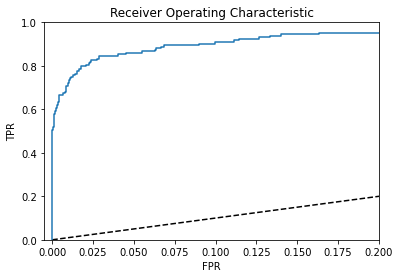

In [11]:
fpr1, tpr1, thresholds1 = roc_curve(test_labels, pred_soft1)
plt.plot([0,1],[0,1], 'k--')
plt.plot(fpr1, tpr1, label= "3gram")
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.title('Receiver Operating Characteristic')
plt.xlim(-0.005, 0.2)
plt.ylim(0, 1)
plt.show()

In [12]:
auc = roc_auc_score(test_labels, pred_soft1)
print('AUC score: {:.4f}'.format(auc))

AUC score: 0.9640
